In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset 
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_chr16'

df = pd.read_csv(froot + ".csv")

In [2]:
print(df.head())

   seqnames   start     end strand  ensembl_gene_id  score      ctcf  \
0        16  245089  245089      +  ENSG00000167930    0.0 -0.039744   
1        16  245090  245090      +  ENSG00000167930    0.0 -0.039511   
2        16  245091  245091      +  ENSG00000167930    0.0 -0.039276   
3        16  245092  245092      +  ENSG00000167930    0.0 -0.039039   
4        16  245093  245093      +  ENSG00000167930    0.0 -0.038799   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts      wgbs  \
0 -0.429633  0.843669  0.003958  ... -0.057178 -0.307549  0.249626  0.000000   
1 -0.431173  0.851792  0.004639  ... -0.057178 -0.307549  0.249626  0.550271   
2 -0.432698  0.859971  0.005313  ... -0.057178 -0.307549  0.249626  0.000000   
3 -0.434205  0.868205  0.005981  ... -0.057178 -0.307549  0.249626  0.000000   
4 -0.435697  0.876495  0.006642  ... -0.057178 -0.307549  0.249626  0.000000   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625 -0.678443  

In [3]:
column_names = np.array(df.columns)
feature_names = column_names[6:-6]
num_features = len(feature_names)
nucleotides = column_names[-6:-2]
print(feature_names)
print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['ctcf' 'h3k36me3' 'h3k4me1' 'h3k79me2' 'h3k9me1' 'h3k9me3' 'h4k20me1'
 'sj5' 'sj3' 'dms' 'rpts' 'wgbs']
['A' 'T' 'G' 'C']


In [4]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 435797


In [5]:
print("Number of Features: " + str(num_features))

Number of Features: 12


In [6]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-6].values

In [7]:
C_j = df['lambda_alphaj'].values

In [8]:
gene_ids = df['ensembl_gene_id'].values

In [9]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: False
Number of GPUs available: 0


In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, GeneId, Y_ji, X_ji, C_j, Z_ji):
        self.GeneId = GeneId
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        return {
            'GeneId':  self.GeneId[idx],
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [11]:
dataset = CustomDataset(gene_ids, Y_ji, X_ji, C_j, Z_ji)

unique_geneids = df['ensembl_gene_id'].unique()
num_unique_geneids = len(unique_geneids)
train_idx = int(num_unique_geneids * 0.80)
val_idx = int(num_unique_geneids * 0.90)

train_geneids = unique_geneids[:train_idx]
validation_geneids = unique_geneids[train_idx:val_idx]
test_geneids = unique_geneids[val_idx:]

train_indices = [i for i, gene_id in enumerate(dataset.GeneId) if gene_id in train_geneids]
val_indices = [i for i, gene_id in enumerate(dataset.GeneId) if gene_id in validation_geneids]
test_indices = [i for i, gene_id in enumerate(dataset.GeneId) if gene_id in test_geneids]


train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64

In [12]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1)

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((batch_size,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

Linear(in_features=12, out_features=1, bias=True)
torch.Size([64, 1])
Number of parameters: 13
Model is on device: cpu


In [13]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        return (loss).mean()

In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

def print_profiler_results(profiler):
    print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))
"""
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    on_trace_ready=print_profiler_results,
    record_shapes=True,
    profile_memory=True
) as profiler:
"""
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(train_set, batch_size=batch_size, num_workers=15, shuffle=False, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
        #profiler.step()
    loss_hist_train[epoch] /= len(trndl)
    del trndl

    
    model.eval()
    valdl = DataLoader(val_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: 0.0410 val_loss: 0.0149
Epoch 2
Epoch 2 trn_loss: 0.0371 val_loss: 0.0146
Epoch 3
Epoch 3 trn_loss: 0.0354 val_loss: 0.0144
Epoch 4
Epoch 4 trn_loss: 0.0344 val_loss: 0.0142
Epoch 5
Epoch 5 trn_loss: 0.0337 val_loss: 0.0140
Epoch 6
Epoch 6 trn_loss: 0.0332 val_loss: 0.0139
Epoch 7
Epoch 7 trn_loss: 0.0328 val_loss: 0.0137
Epoch 8
Epoch 8 trn_loss: 0.0325 val_loss: 0.0136
Epoch 9
Epoch 9 trn_loss: 0.0323 val_loss: 0.0136
Epoch 10
Epoch 10 trn_loss: 0.0321 val_loss: 0.0135
Epoch 11
Epoch 11 trn_loss: 0.0320 val_loss: 0.0134
Epoch 12
Epoch 12 trn_loss: 0.0319 val_loss: 0.0134
Epoch 13
Epoch 13 trn_loss: 0.0318 val_loss: 0.0133
Epoch 14
Epoch 14 trn_loss: 0.0317 val_loss: 0.0133
Epoch 15
Epoch 15 trn_loss: 0.0316 val_loss: 0.0132
Epoch 16
Epoch 16 trn_loss: 0.0315 val_loss: 0.0132
Epoch 17
Epoch 17 trn_loss: 0.0315 val_loss: 0.0131
Epoch 18
Epoch 18 trn_loss: 0.0314 val_loss: 0.0131
Epoch 19
Epoch 19 trn_loss: 0.0314 val_loss: 0.0131
Epoch 20
Epoch 20 trn_loss: 0.

In [15]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Model_chr16_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [107]:
"""
model = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("models/Elongation_Model.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
"""

CUDA (GPU support) is available: True
Number of GPUs available: 1
Model is on device: cuda:0


In [16]:
weights = model.weight.data.cpu().numpy()
bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

"ctcf": 0.010853282175958157, "h3k36me3": -0.06529039889574051, "h3k4me1": -0.006691562943160534, "h3k79me2": 0.05777670443058014, "h3k9me1": -0.05916871130466461, "h3k9me3": -0.09455890208482742, "h4k20me1": -0.06147964671254158, "sj5": -0.02029029279947281, "sj3": -0.013147097080945969, "dms": -0.07349317520856857, "rpts": 0.01619826629757881, "wgbs": -0.08812040835618973


In [ ]:
"""
GLM K

* ctcf: -0.02
* h3k36me3: -0.9
* h3k4me1: -0.02
* h3k79me2: +0.03
* h3k9me1: -0.06
* h3k9me3: -0.03
* h4k20me1: -0.05
* sj5: -0.02
* sj3: -0.03
* dms: ?
* rpts: 
* wgbs: ?
"""

<function matplotlib.pyplot.show(close=None, block=None)>

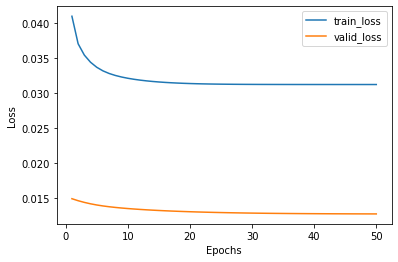

In [17]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [18]:
def plot_data(simulated_zeta, predicted_zeta):
    indices = range(len(simulated_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(indices, predicted_zeta, color='blue', alpha=0.4)
    ax.plot(indices, simulated_zeta, color='orange', alpha=0.4)
    
    ax.scatter(indices, predicted_zeta, color='blue', label='Predicted Zeta')
    ax.scatter(indices, simulated_zeta, color='orange', label='Simulated Zeta')
    
    ax.set_title('Predicted vs Simulated Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()

    plt.show()


In [19]:
tstdl = DataLoader(test_set, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

In [20]:
model.eval()

data_iter = iter(tstdl)

number of samples: 5
predicted zeta:
tensor([1.1067, 1.1062, 1.1057, 1.1051, 1.1046, 1.1065, 1.1060, 1.1054, 1.1049,
        1.0521, 1.1038, 1.1033, 1.1027, 1.1021, 1.1016, 1.0986, 1.0980, 1.0975,
        1.0969, 1.0963, 1.0957, 1.0951, 1.0945, 1.0939, 1.0933, 1.0857, 1.0851,
        1.0845, 1.0839, 1.0833, 1.0827, 1.0820, 1.0814, 1.0808, 1.0802, 1.0684,
        1.0678, 1.0672, 1.0665, 1.0659, 1.0653, 1.0646, 1.0640, 1.0634, 1.0627,
        1.0475, 1.0468, 1.0462, 1.0456, 1.0450, 1.0443, 1.0437, 1.0431, 1.0424,
        1.0418, 1.0239, 1.0232, 1.0226, 1.0220, 1.0214, 1.0207, 1.0201, 1.0195,
        1.0189])
simulated zeta:
tensor([1.1225, 1.1221, 1.1216, 1.1211, 1.1207, 1.1226, 1.1221, 1.1216, 1.1211,
        0.9253, 1.1201, 1.1196, 1.1191, 1.1186, 1.1181, 1.1152, 1.1146, 1.1141,
        1.1136, 1.1130, 1.1125, 1.1120, 1.1114, 1.1109, 1.1103, 1.1028, 1.1022,
        1.1017, 1.1011, 1.1006, 1.1000, 1.0994, 1.0989, 1.0983, 1.0977, 1.0861,
        1.0855, 1.0849, 1.0843, 1.0838, 1.0832, 1.

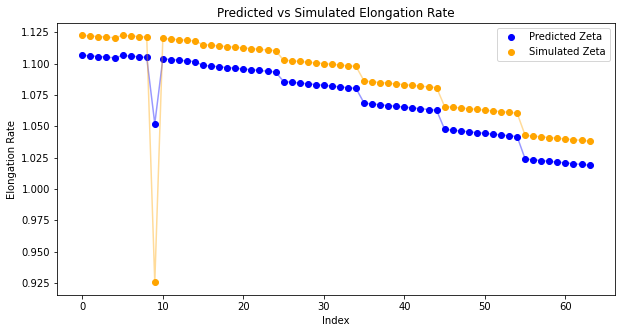

number of samples: 5
predicted zeta:
tensor([1.0183, 0.9986, 0.9979, 0.9973, 0.9496, 0.9961, 0.9955, 0.9949, 0.9943,
        0.9937, 0.9931, 0.9725, 0.9719, 0.9254, 0.9708, 0.9702, 0.9696, 0.9690,
        0.9685, 0.9679, 0.9673, 1.0066, 1.0560, 1.0554, 1.0548, 1.0542, 1.0536,
        1.0031, 1.0524, 1.0518, 1.0512, 1.0506, 1.0500, 1.0494, 1.0489, 1.0483,
        1.0477, 1.0472, 1.0466, 1.0460, 1.0455, 1.0449, 1.0444, 1.0439, 1.0433,
        1.0428, 1.0423, 1.0417, 1.0412, 1.0407, 1.0402, 1.0397, 1.0392, 1.0387,
        1.0382, 1.0377, 1.0373, 1.0368, 1.0363, 1.0359, 1.0354, 1.0349, 1.0345,
        1.0340])
simulated zeta:
tensor([1.0376, 1.0180, 1.0174, 1.0169, 0.8392, 1.0157, 1.0152, 1.0146, 1.0141,
        1.0135, 1.0130, 0.9925, 0.9920, 0.8187, 0.9909, 0.9904, 0.9898, 0.9893,
        0.9888, 0.9883, 0.9878, 0.8892, 1.0763, 1.0758, 1.0752, 1.0747, 1.0741,
        0.8865, 1.0730, 1.0725, 1.0720, 1.0714, 1.0709, 1.0704, 1.0698, 1.0693,
        1.0688, 1.0683, 1.0678, 1.0673, 1.0668, 1.

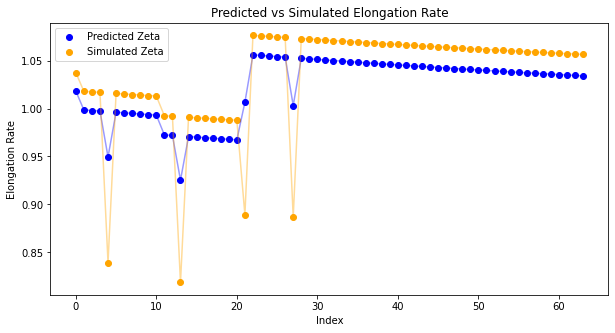

number of samples: 5
predicted zeta:
tensor([1.0336, 1.0332, 1.0327, 1.0323, 1.0319, 1.0315, 1.0311, 1.0307, 1.0303,
        0.9812, 1.0295, 1.0291, 1.0288, 1.0284, 1.0280, 1.0277, 1.0273, 1.0270,
        1.0267, 1.0263, 1.0260, 1.0257, 1.0254, 1.0250, 1.0247, 1.0244, 1.0242,
        1.0239, 1.0236, 1.0233, 1.0230, 1.0228, 1.0225, 1.0223, 1.0220, 1.0218,
        1.0215, 1.0213, 1.0211, 1.0208, 1.0206, 1.0204, 1.0202, 1.0200, 1.0198,
        1.0196, 1.0195, 1.0193, 1.0191, 1.0189, 1.0188, 1.0186, 1.0185, 1.0183,
        1.0182, 1.0180, 1.0179, 1.0178, 1.0177, 1.0175, 1.0174, 1.0173, 1.0172,
        1.0171])
simulated zeta:
tensor([1.0560, 1.0556, 1.0552, 1.0548, 1.0545, 1.0541, 1.0537, 1.0534, 1.0530,
        0.8692, 1.0523, 1.0519, 1.0516, 1.0513, 1.0509, 1.0506, 1.0503, 1.0500,
        1.0496, 1.0493, 1.0490, 1.0487, 1.0484, 1.0481, 1.0479, 1.0476, 1.0473,
        1.0470, 1.0468, 1.0465, 1.0462, 1.0460, 1.0457, 1.0455, 1.0452, 1.0450,
        1.0448, 1.0445, 1.0443, 1.0441, 1.0439, 1.

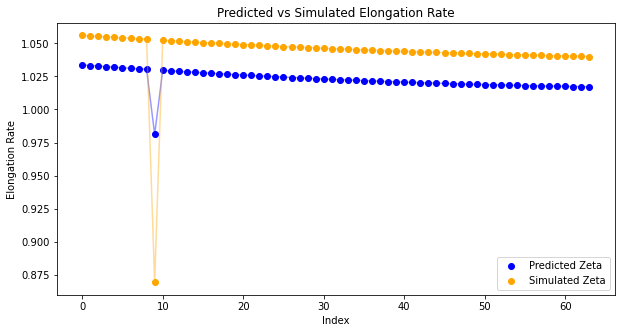

number of samples: 5
predicted zeta:
tensor([1.0170, 1.0169, 1.0168, 1.0168, 1.0167, 1.0166, 1.0166, 1.0165, 1.0164,
        1.0164, 1.0163, 1.0163, 1.0162, 1.0162, 1.0161, 1.0161, 1.0161, 1.0161,
        1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160,
        1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0161, 1.0161, 1.0161,
        1.0161, 1.0162, 1.0162, 1.0162, 1.0163, 1.0163, 1.0163, 1.0164, 1.0164,
        1.0165, 1.0165, 1.0166, 1.0166, 1.0166, 1.0167, 1.0167, 1.0168, 1.0169,
        1.0169, 1.0170, 1.0170, 1.0171, 1.0171, 1.0172, 1.0172, 1.0173, 1.0174,
        1.0174])
simulated zeta:
tensor([1.0399, 1.0398, 1.0396, 1.0395, 1.0394, 1.0393, 1.0392, 1.0391, 1.0390,
        1.0389, 1.0388, 1.0387, 1.0386, 1.0385, 1.0384, 1.0383, 1.0382, 1.0382,
        1.0381, 1.0380, 1.0379, 1.0378, 1.0378, 1.0377, 1.0376, 1.0376, 1.0375,
        1.0374, 1.0374, 1.0373, 1.0372, 1.0372, 1.0371, 1.0371, 1.0370, 1.0369,
        1.0369, 1.0368, 1.0368, 1.0367, 1.0367, 1.

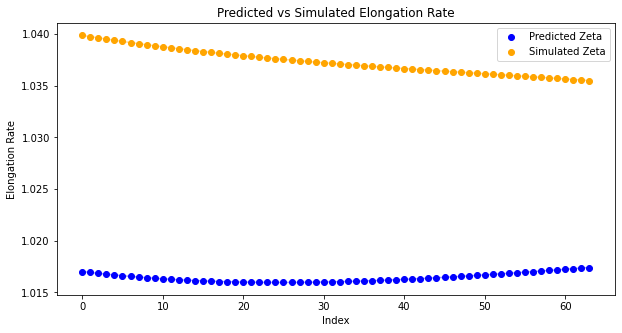

In [23]:
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)

    simulated_zeta = inputs['Z_ji']
    # convert log(Z) outputs to Z
    predicted_zeta = torch.exp(rho_ji.cpu().squeeze())
    print("predicted zeta:")
    print(predicted_zeta)

    print("simulated zeta:")
    print(simulated_zeta)

    plot_data(simulated_zeta, predicted_zeta)

In [114]:
import torch.nn.functional as F

predicted_zeta = []
simulated_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        predicted_zeta.append(torch.exp(rho_ji.cpu()))
        simulated_zeta.append(batch['Z_ji'])

predicted_zeta = torch.cat(predicted_zeta, dim=0)
simulated_zeta = torch.cat(simulated_zeta, dim=0)
mae = F.l1_loss(predicted_zeta.squeeze(), simulated_zeta)
mse = F.mse_loss(predicted_zeta.squeeze(), simulated_zeta)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Mean Absolute Error: 1.4545
Mean Squared Error: 2.1965
